In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KDTree

### Functions for ROC stuff

In [ ]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

### Import the data

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Makes lists of the different types

In [3]:
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

### Dataframes of each type of data

In [4]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age ordinal

In [5]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [6]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [7]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Function for setting up the training, validation, and test sets

In [8]:
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 seperate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting allof the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [9]:
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_hot_med_x, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

((61059, 251), (20353, 251), (20354, 251))

# KNN - ...JK not yet

In [59]:
%%time
#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_tst)

Wall time: 28.9 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


### PCA on scaled values

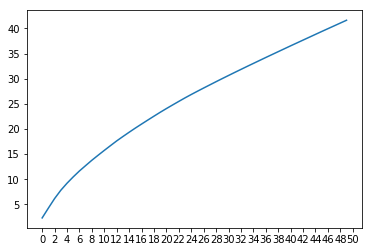

In [31]:
#Maximum number of components to show
comp = 50
pca = PCA(n_components = comp)
pca.fit(x_t)

#The amount of variance that each PC explains
var = pca.explained_variance_ratio_

#Cumulative Variance explains
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#Making there be lots of ticks on the x axis
plt.xticks(np.arange(0, comp+1, 2.0))
plt.plot(var1)

### PCA just looking at first 3

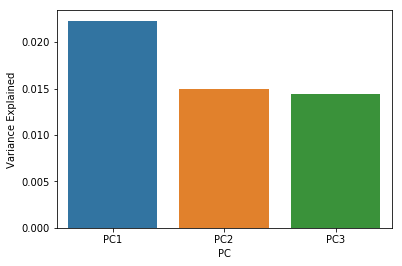

In [37]:
pca1 = PCA(n_components = 3)
principalComponents = pca1.fit_transform(x_t)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

#Creating the dataframe for the scree plot
x_t_scree = pd.DataFrame( {'Variance Explained':pca1.explained_variance_ratio_,'PC':['PC1','PC2','PC3']} )
sns.barplot(x = 'PC', y = "Variance Explained", data = x_t_scree)

### Amount of correlation, after doing hot encoding, sorted

In [23]:
df_zg_corr = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, df_zg_response], axis = 1)
cors = df_zg_corr.corr()
cors = cors.sort_values(by=['readmitted_tf'])
cors.readmitted_tf

discharge_disposition_id_11                         -0.118405
discharge_disposition_id_1                          -0.116581
meds_increased_0                                    -0.099734
admission_type_id_3                                 -0.091221
diabetesMed_No                                      -0.083035
admission_source_id_1                               -0.077781
admission_source_id_2                               -0.076590
admission_type_id_4                                 -0.056889
discharge_disposition_id_14                         -0.049028
change_No                                           -0.046008
discharge_disposition_id_13                         -0.044504
race_Unspecified                                    -0.042900
medical_specialty_ObstetricsandGynecology           -0.040739
diag_3_val_None                                     -0.038082
medical_specialty_Orthopedics-Reconstructive        -0.033022
medical_specialty_Surgery-Cardiovascular/Thoracic   -0.031501
medical_

### Make dataframe of columns that had correlation >= |0.1|

In [ ]:
nm = ["num_medications", "number_diagnoses", "admission_source_id", "time_in_hospital",
      "admission_source_id", "number_emergency", "num_lab_procedures", "admission_type_id",
      "number_inpatient", "discharge_disposition_id"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

scl = StandardScaler()
df_zg_PCA_scl = scl.fit_transform(df_zg_minPCA)

### Do PCA on that smaller dataset

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


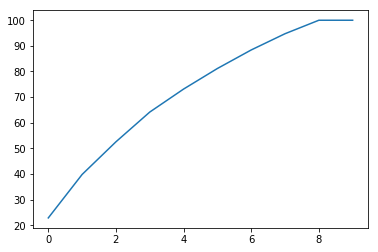

In [32]:
#Maximum number of components to show
comp = 10
pca = PCA()
pca.fit(df_zg_PCA_scl)

#The amount of variance that each PC explains
var = pca.explained_variance_ratio_

#Cumulative Variance explains
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#Making there be lots of ticks on the x axis
plt.xticks(np.arange(0, comp+1, 2.0))
plt.plot(var1)

# KNN with variables based on correlation >= |0.1|

### Do the split again, just for safety

In [60]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_tst)

Wall time: 51.9 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


### Doing the KNN

In [61]:
%%time
# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors = 27)
clf.fit(x_t, y_t)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 3.02 s


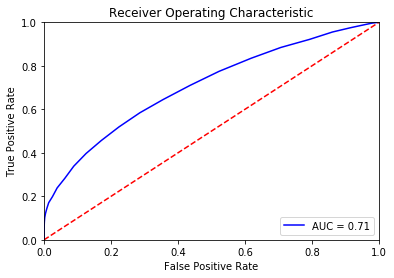

F1: 0.6453246913559881 ACC: 0.6447698128040092 AUC: 0.7067714813237308 
Confusion Matrix
 [[7101 3914]
 [3316 6022]]
Wall time: 18.7 s


In [62]:
%%time
#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_t)
cutoff = Find_Optimal_Cutoff(y_t, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = clf.predict_proba(x_v)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_v)

#Accuracy metrics
f1 = f1_score(y_v, y_pred, average = 'weighted')
acc = accuracy_score(y_v, y_pred)
roc = roc_auc_score(y_v, y_pred_probs[:,1])
#roc = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
conf = mt.confusion_matrix(y_v, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)